# NASA Carbon Monitoring System (CMS) Estimated Global Mangroves in the 2000s Notebook

### Overview 
Selected [NASA Carbon Monitoring System (CMS) Estimated Global Mangroves in the 2000s](https://nasa.maps.arcgis.com/home/item.html?id=7a4b74ebb65c453482c15554db02cedf) layer data have been processed into a free, publicly available ArcGIS image service that provides analysis-ready, 30-meter resolution estimates of global mangrove distribution, aboveground biomass, and canopy height for the 2000s.

This notebook illustrates the following:

* Connect to the NASA CMS Global Mangrove ArcGIS ImageService
* Inspect service metadata to understand available variables and structure
* Define an Area of Interest (AOI) using a geographic bounding box (envelope)
* Retrieve a subset of representative mangrove pixel samples (`agb`, `hba`, `hmax`) within the AOI
* Clean and filter sampled values to identify pixels containing valid mangrove data
* Calculate summary statistics for mangrove variables within the AOI
* Visualize the distribution of a selected mangrove variable using a histogram
* Display the mangrove imagery, AOI, and sampled pixel locations in an interactive map

**Why ArcGIS image services?**  
The CMS Global Mangrove Layer is published as an ArcGIS image service, hosted at a service URL with several built-in functions exposed through the [ArcGIS Image Service REST API](https://developers.arcgis.com/rest/services-reference/enterprise/image-service/). These capabilities (e.g., pixel queries, raster functions, image subsetting, and statistics) can be accessed via web interfaces or called programmatically, providing flexible ways to access, analyze, and display global mangrove data.

### Prerequisites

Note: ESRI software/licenses are **not** required to access the image service via the REST interfaces or programmatically. No desktop GIS software is required to use this CMS layer (although there are many ways to bring the service into GIS tools).

**Required:**
- Basic Python knowledge (variables, loops, functions)
- Familiarity with mangrove ecosystems and/or NASA CMS mangrove products (distribution, biomass, canopy height)

**Python Libraries:**
- [requests](https://github.com/psf/requests) – sending HTTP requests to the image service REST API  
- [numpy](https://numpy.org/) – numerical operations
- [pandas](https://pandas.pydata.org/) – tabular data handling and summaries
- [matplotlib](http://matplotlib.org/) – plotting and visualization
- [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) – interactive mapping


### Data & Scope

The CMS Global Mangrove Layer has an ArcGIS portal item page with detailed descriptions of the dataset, including the variables, methods, spatial resolution, and access to the online map viewer. It is strongly recommended to read the full service description to understand the underlying data products and modeling approach.

The mangrove layer is available as an Esri [Living Atlas of the World](https://livingatlas.arcgis.com/en/browse/?q=mangrove#q=mangrove&d=2) imagery layer contributed by NASA’s Carbon Monitoring System and surfaced through the NASA ArcGIS Online organization. 

This notebook uses:

- **Product**: NASA Carbon Monitoring System (CMS) Estimated Global Mangroves in the 2000s  
  - Global, 30-meter resolution estimates of mangrove **distribution**, **aboveground biomass**, and **canopy height**, representing conditions in the 2000s.
  - **Variables**:
    - **agb (Mg ha-1)**: mangrove aboveground biomass measured in *megagrams per hectare*
    - **hmax (meters)**: maximum canopy maximum height (height of the tallest tree) measured in *meters*
    - **hba (meters)**: basal-area weighted height (individual tree heights weighted in proportion to their basal area).
- **Resolution**: 30 m  
- **Coverage**: Global mangrove-bearing coastlines  
- **Example region**: Everglades National Park area, Florida, USA

*Methods demonstrated in this notebook apply to other mangrove regions worldwide and can be adapted to different variables within the CMS Global Mangrove Layer.*

Because this is a **one-time global snapshot** rather than a time series, the primary “dimension” in this service is the variable (distribution, biomass, canopy height), not time. Temporal analyses (e.g., change over time) can be performed by combining this baseline with other datasets or time-varying products.

### Notebook Author / Affiliation

- Author: Earthdata GIS / NASA Carbon Monitoring System (CMS)  
- Questions? Please post questions on the [NASA Earthdata Forum](https://forum.earthdata.nasa.gov/)


## 1. Setup
In this section, you will:

1. Install and import libraries
2. Define the ImageService URL
3. Request and inspect metadata
4. Define an Area of Interest (AOI)

### 1.1 Install Python packages

In [1]:
# Uncomment the line below if these packages are not already installed
# !pip install requests numpy pandas matplotlib ipyleaflet

### 1.2 Import Python libraries

In [2]:
# --- Standard library: basic utilities ---
import json                    # For encoding/decoding JSON payloads

# --- HTTP requests & data handling ---
import requests                # For calling the ArcGIS REST ImageServer
import numpy as np             # For numerical operations and raster arrays
import pandas as pd            # For tabular data handling (samples, summaries)


# --- Plotting & visualization ---
import matplotlib.pyplot as plt   # For histograms and summary plots


# --- Interactive mapping (ipyleaflet): display imagery & markers ---
from ipyleaflet import (
    Map,                        # Base interactive map widget
    basemaps,                   # Predefined basemap options (Esri, OSM, etc.)
    basemap_to_tiles,           # Convert basemap to tile layer
    Rectangle,                  # Draw AOI extents
    LayersControl,              # Layer toggle control
    ImageService,               # Stream ImageServer imagery as a layer
    CircleMarker,               # Display sampled pixel locations
    LayerGroup,                 # Group sample markers into one toggleable layer
    WidgetControl,              # Add coordinate labels & widgets to the map
)


# --- Jupyter widgets & display helpers ---
from ipywidgets import HTML     # For coordinate display overlay
from IPython.display import display   # For inline map + table rendering

print("Python libraries imported successfully!")

Python libraries imported successfully!


### 1.3 Assign Service URL

In [3]:
service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C2389107206-ORNL_CLOUD/CMS_Global_Map_Mangrove_Canopy_1665/ImageServer"

print(f"service_url successfully assigned to {service_url}")

service_url successfully assigned to https://gis.earthdata.nasa.gov/image/rest/services/C2389107206-ORNL_CLOUD/CMS_Global_Map_Mangrove_Canopy_1665/ImageServer


## 1.4 Explore ImageService metadata

Before working with the data, it helps to understand how the image service is structured. ArcGIS Image Services expose metadata through a REST endpoint that describes available variables, how pixel values are stored, and the spatial or temporal structure of the service.

In this step, we programmatically request the ImageServer metadata and inspect a small set of fields that are most relevant for analysis. You can also explore this information directly through the [ArcGIS REST Services Directory](https://gis.earthdata.nasa.gov/image/rest/services/C2389107206-ORNL_CLOUD/CMS_Global_Map_Mangrove_Canopy_1665/ImageServer).

### What we explore

- **Service Name** – Confirms which dataset we are working with  
- **Pixel Type** – Indicates how pixel values are stored (e.g., 32-bit floating point)  
- **Band Count** – Number of raster bands returned in a single export  
- **Has Multi Dimensions** – Indicates whether the service exposes multiple variables or dimensions  
- **Spatial Reference** – Coordinate system used by the service  

> **Note:** In multidimensional image services, multiple variables may be available even when the band count is 1. Variables are accessed as separate multidimensional slices rather than as separate raster bands. In this service, agb, hba, and hmax are exposed as multidimensional variables rather than separate raster bands.

The full metadata dictionary contains many additional fields. You can optionally inspect all available metadata keys to explore advanced capabilities.


In [4]:
# 1.4 Explore ImageService metadata

def get_service_metadata(service_url: str = service_url) -> dict:
    """
    Request and return basic metadata for an ArcGIS image service.
    """
    params = {"f": "json"}
    resp = requests.get(service_url, params=params)
    resp.raise_for_status()
    return resp.json()


metadata = get_service_metadata(service_url)

# Explore Key Fields
print("Service Name:", metadata.get("name"))
print("Pixel Type:", metadata.get("pixelType"))
print("Band Count:", metadata.get("bandCount"))
print("Has Multi Dimensions:", metadata.get("hasMultidimensions"))
print("Spatial Reference:", metadata.get("spatialReference"))

# Optional: uncomment to inspect all metadata keys
# list(metadata.keys())

Service Name: C2389107206-ORNL_CLOUD/CMS_Global_Map_Mangrove_Canopy_1665
Pixel Type: F32
Band Count: 1
Has Multi Dimensions: True
Spatial Reference: {'wkid': 4326, 'latestWkid': 4326}


### 1.5 Define Area of Interest (AOI)

An AOI defines the geographic region used for sampling, analysis, and visualization in this notebook. Here, we represent the AOI as a **bounding box** (envelope) defined by minimum and maximum longitude and latitude values in WGS 84 (EPSG:4326). The `make_bbox()` function converts these coordinates into the geometry format required by the ArcGIS ImageServer REST API. This geometry will be reused throughout the notebook when querying, sampling, and visualizing the mangrove data.

You can update the coordinate values below to explore a different region.
> **Troublehooting:** If valid_pixels is 0 (or very low), your AOI may not intersect mangrove areas. Try adjusting the bounding box to a known mangrove area or shrink bounding box size and re-run the sampling cells.


In [5]:
# 1.5 Define AOI

def make_bbox(
    lon_min: float,
    lat_min: float,
    lon_max: float,
    lat_max: float,
    wkid: int = 4326,
) -> dict:
    """
    Create an envelope geometry for use in ArcGIS REST API calls.

    Parameters
    ----------
    lon_min, lat_min, lon_max, lat_max : float
        Bounding box coordinates in longitude/latitude.
    wkid : int, optional
        Spatial reference WKID. Default is 4326 (WGS 84).

    Returns
    -------
    dict
        Dictionary in the format expected by the ArcGIS REST API.
    """
    return {
        "xmin": lon_min,
        "ymin": lat_min,
        "xmax": lon_max,
        "ymax": lat_max,
        "spatialReference": {"wkid": wkid},
    }


# Default AOI: Everglades National Park area, Florida, USA
aoi_bbox = make_bbox(
    lon_min=-81.174,  # west
    lat_min=25.144,   # south
    lon_max=-80.891,  # east
    lat_max=25.362,   # north
)

print("AOI bounding box:", aoi_bbox)


AOI bounding box: {'xmin': -81.174, 'ymin': 25.144, 'xmax': -80.891, 'ymax': 25.362, 'spatialReference': {'wkid': 4326}}


## 2. Analysis
In this section, you will:

1. Sample pixel values inside your AOI using the ImageServer `getSamples` endpoint  
2. Convert the samples into a DataFrame
3. Clean and filter the DataFrame
4. Calculate summary statistics in your AOI with `describe()`
5. Visualize distributions with a histogram

### 2.1 GetSamples

In this step, we use the ImageServer `getSamples` endpoint to **retrieve a subset of representative pixel samples** within the AOI. The `getSamples` operation does **not** return every pixel in the AOI. Instead, it returns a limited number of sample points distributed across the region. This provides a quick way to explore the data without downloading a full raster.

We then convert the returned samples into a pandas DataFrame, where:
- each row represents a sampled pixel location  
- `x` and `y` store the longitude and latitude of the sample  
- remaining columns contain mangrove variables

**Why use sampling?**
- quickly inspecting data values  
- exploring variable distributions  
- validating that the AOI overlaps areas with mangrove data  

In [14]:
# 2.1 Sample mangrove pixels in the AOI using getSamples

def sample_mangrove_values(
    service_url: str,
    geometry: dict,
    sample_count: int = 1200,
    band_ids = None,
    geometry_type: str = "esriGeometryEnvelope",
) -> dict:
    """
    Call the ArcGIS ImageServer getSamples endpoint to retrieve sample pixel values
    within a given geometry.
    """
    params = {
        "f": "json",
        "geometry": json.dumps(geometry),
        "geometryType": geometry_type,
        "sampleCount": sample_count,
        "returnFirstValueOnly": False,
    }
    if band_ids is not None:
        params["bandIds"] = band_ids

    url = service_url.rstrip("/") + "/getSamples"
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    return resp.json()


def samples_to_dataframe(samples_json: dict, column_vars=("agb", "hba", "hmax")) -> pd.DataFrame:
    """
    Convert an ImageServer getSamples JSON response into a pandas DataFrame.

    Assumes each 'sample' has:
      - a 'location' dict with 'x' and 'y'
      - mangrove variable values
    """
    samples = samples_json.get("samples", [])
    rows = []

    for s in samples:
        loc = s.get("location", {})
        row = {
            "x": loc.get("x"),
            "y": loc.get("y"),
        }

        attrs = s.get("attributes", {})
        for var in column_vars:
            if var in attrs:
                row[var] = attrs[var]

        rows.append(row)

    return pd.DataFrame(rows)


# Example: sample 1,200 points in the AOI
samples_json = sample_mangrove_values(service_url, aoi_bbox, sample_count=1200)
print(f"Number of samples returned: {len(samples_json.get('samples', []))}")

aoi_df = samples_to_dataframe(samples_json)
display(aoi_df.head())

Number of samples returned: 1008


,x,y,agb,hba,hmax
0,-81.170073,25.358073,,,
1,-81.162218,25.358073,,,
2,-81.154364,25.358073,,,
3,-81.146509,25.358073,,,
4,-81.138655,25.358073,,,


### 2.2 Filtering and cleaning sampled values

Although CMS Global Mangrove ImageService stores pixel values as **32-bit floating point numbers (Pixel Type: F32)**, values returned by the ImageServer **getSamples** operation are transmitted through the REST API as **JSON text**. As a result, mangrove variables (`agb`, `hba`, `hmax`) may appear as **strings** when first loaded into a pandas DataFrame. Additionally, `getSamples` distributes sample points across the entire Area of Interest (AOI), including locations where mangroves are not present. For these non-mangrove pixels, the mangrove variables are returned as **empty values**.

In this context, **“invalid” entries** refer to:
- Empty values returned for pixels outside mangrove-covered areas  
- Non-numeric values that cannot be converted to floating-point numbers  

In this step, we clean the sampled data by:
- Converting mangrove variables (`agb`, `hba`, `hmax`) from strings to numeric values  
- Coercing empty or non-numeric entries to `NaN`  
- Counting how many sampled pixels contain valid mangrove data

This step ensures that subsequent analysis reflects mangrove conditions only and provides data coverage information for the AOI.

In [7]:
# Mangrove Variables
mangrove_vars = ["agb", "hba", "hmax"]

def clean_mangrove_variables(df: pd.DataFrame, var_cols=None) -> pd.DataFrame:
    """
    Convert mangrove variable columns from strings to numeric,
    coercing invalid/empty values to NaN.
    """
    if var_cols is None:
        var_cols = mangrove_vars

    df = df.copy()
    for col in var_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


def count_valid_pixels(df: pd.DataFrame, var_cols=None) -> pd.DataFrame:
    """
    Count how many pixels in the AOI have valid (non-NaN) values
    for each mangrove variable.
    """
    if var_cols is None:
        var_cols = mangrove_vars

    rows = []
    total = len(df)
    for col in var_cols:
        if col in df.columns:
            valid = df[col].notna().sum()
            rows.append(
                {
                    "variable": col,
                    "valid_pixels": valid,
                    "total_samples": total,
                    "percent_valid": round(100 * valid / total, 1),
                }
            )
    return pd.DataFrame(rows)


# 1. Clean variables (convert empty strings to NaN, cast to float)
aoi_df_clean = clean_mangrove_variables(aoi_df, mangrove_vars)

# 2. How many pixels actually have mangrove data?
valid_counts = count_valid_pixels(aoi_df_clean, mangrove_vars)
print("Valid pixel counts per variable in this AOI:")
display(valid_counts)

Valid pixel counts per variable in this AOI:


,variable,valid_pixels,total_samples,percent_valid
0,agb,522,1008,51.8
1,hba,522,1008,51.8
2,hmax,522,1008,51.8


### 2.3 Summary Statistics for Mangrove Variables in the AOI

With the Mangrove DataFrame cleaned and validated, we can now compute basic summary statistics for each mangrove variable.
These statistics (min, max, mean, quartiles, etc.) help characterize how mangrove structure varies within the AOI.

In [8]:
def summarize_mangrove_variables(df: pd.DataFrame, var_cols=None) -> pd.DataFrame:
    """
    Return a table of basic summary statistics for each mangrove variable
    in the AOI (min, max, mean, etc.).
    """
    if var_cols is None:
        var_cols = mangrove_vars

    numeric = df[var_cols].copy()
    summary = numeric.describe().T  # variables as rows
    summary = summary.rename_axis("variable").reset_index()
    return summary

# 3. Summary statistics for the AOI
summary_stats = summarize_mangrove_variables(aoi_df_clean, mangrove_vars)
print("Summary statistics for mangrove variables in AOI:")
display(summary_stats)

Summary statistics for mangrove variables in AOI:


,variable,count,mean,std,min,25%,50%,75%,max
0,agb,522.0,33.574989,27.386183,0.524186,14.718429,21.05163,44.735607,97.458557
1,hba,522.0,6.648115,3.536452,0.537700,4.301600,5.37700,8.603200,13.980200
2,hmax,522.0,10.490841,5.580582,0.848500,6.788000,8.48500,13.576000,22.061001


### 2.4 Plot Histogram

In this step, we plot a histogram for a selected mangrove variable to examine how values are distributed across the AOI.

The histogram shows:

- how frequently different values occur  
- whether the distribution is skewed or symmetric  
- the presence of outliers or extreme values  

Before plotting, define out variable units and remove missing (`NaN`) and infinite values to ensure the visualization reflects valid mangrove pixels only. You can switch between mangrove variables (`agb`, `hba`, or `hmax`) to compare how their distributions differ within the AOI.

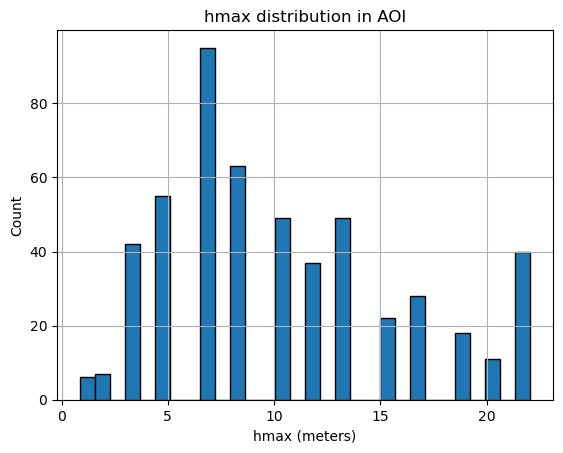

In [18]:
var_units = {
    "agb": "megagrams per hectare",
    "hba": "meters",
    "hmax": "meters",
}

def plot_histogram(series: pd.Series, title: str, bins: int = 30):
    """
    Plot a simple histogram for a numeric pandas Series.
    """
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()

    plt.figure()
    plt.hist(clean, bins=bins, edgecolor="black")
    plt.title(title)
    plt.xlabel(f"{selected_var} ({var_units.get(selected_var, '')})")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


# Choose one of the mangrove variables to visualize
selected_var = "hmax"        # maximum canopy maximum height (meters)
# selected_var = "agb"         # mangrove aboveground biomass (megagrams per hectare)
# selected_var = "hba"         # basal-area weighted height (meters) 

plot_histogram(
    aoi_df_clean[selected_var],
    title=f"{selected_var} distribution in AOI",
)

## 3. Mapping and Visualization

In this section, we use **ipyleaflet** to build an interactive map so we can visualize our AOI and sampled pixels.

To build the map, we define two helper functions:

- `get_bbox_bounds()` converts the AOI geometry dictionary into bounds that ipyleaflet understands.
- `map_mangroves()` creates the interactive map and adds:
  - A basemap
  - The CMS Mangrove ImageService raster
  - The AOI bounding box
  - Sampled pixel locations

We also attach simple coordinate tools to the map using `coordinate_tool()`. These tools make it easy to identify coordinates of interest and reuse them to define a new AOI.

In [10]:
def coordinate_tool(m: Map) -> Map:
    """
    Add hover + click coordinate display to an ipyleaflet map.
    - Hover: shows live coordinates in the bottom-right
    - Click: prints coordinates to the notebook output
    """
    coordinates_label = HTML(value="Coordinates: ")
    coordinates_control = WidgetControl(widget=coordinates_label, position="bottomright")
    m.add_control(coordinates_control)

    def on_interaction(**kwargs):
        if kwargs.get("type") == "click":
            print("Coordinates latitude (y), longitude (x):", kwargs.get("coordinates"))

        if kwargs.get("type") == "mousemove":
            lat, lng = kwargs.get("coordinates")
            coordinates_label.value = f"Coordinates: ({lat:.5f}, {lng:.5f})"

    m.on_interaction(on_interaction)
    return m


def get_bbox_bounds(geometry: dict):
    xmin = geometry["xmin"]
    ymin = geometry["ymin"]
    xmax = geometry["xmax"]
    ymax = geometry["ymax"]
    return (ymin, xmin), (ymax, xmax)


def map_mangroves(
    geometry: dict,
    zoom: int = 7,
    service_url: str = service_url,
    opacity: float = 0.6,
    samples_df = None,
    mangrove_vars = None,
    add_coordinates: bool = True,
) -> Map:
    """
    Create an ipyleaflet map with:
      - Basemap
      - CMS mangrove ImageService layer
      - AOI rectangle
      - Optional sampled pixel locations
      - Optional coordinate tool (hover + click)
    """
    if mangrove_vars is None:
        mangrove_vars = ["agb", "hba", "hmax"]

    (south, west), (north, east) = get_bbox_bounds(geometry)
    center_lat = (south + north) / 2.0
    center_lon = (west + east) / 2.0

    m = Map(
        center=(center_lat, center_lon),
        zoom=zoom,
        basemap=basemap_to_tiles(basemaps.Esri.WorldTopoMap),
    )

    # Raster imagery layer
    mangrove_layer = ImageService(
        url=service_url,
        format="jpgpng",
        opacity=opacity,
        name="CMS Mangrove",
    )
    m.add_layer(mangrove_layer)

    # AOI outline
    rect = Rectangle(
        bounds=((south, west), (north, east)),
        fill=False,
        weight=3,
        color="red",
        name="AOI",
    )
    m.add_layer(rect)

    # Optional sample points layer
    if samples_df is not None and not samples_df.empty:
        df = samples_df.copy()

        for col in mangrove_vars:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        present_cols = [c for c in mangrove_vars if c in df.columns]

        markers = []
        for _, row in df.iterrows():
            lat = row.get("y")
            lon = row.get("x")

            if pd.isna(lat) or pd.isna(lon):
                continue

            has_mangrove = row[present_cols].notna().any() if present_cols else False
            fill_color = "lawngreen" if has_mangrove else "lightgrey"

            markers.append(
                CircleMarker(
                    location=(lat, lon),
                    radius=2,
                    color=fill_color,
                    fill=True,
                    fill_color=fill_color,
                    fill_opacity=0.8,
                )
            )

        m.add_layer(LayerGroup(layers=markers, name="Sampled Locations"))

    m.add_control(LayersControl())

    if add_coordinates:
        m = coordinate_tool(m)

    return m


### 3.1 Explore the Map

The map includes:

- **CMS Mangrove ImageService layer** (the raster image service)
  - **Black** = Valid mangrove pixel
- **AOI outline** (a red rectangle showing the bounding box used in our API requests)
- **Optional sampled locations** (points returned by `getSamples`)
  - **Green** = at least one mangrove variable (`agb`, `hba`, or `hmax`) contains a valid numeric value  
  - **Gray** = no mangrove values at that sampled location (non-mangrove / no-data)

> **Tip:** Use the **Layers** control (top-right of the map) to toggle map layers on and off. You can turn the mangrove image, AOI boundary, and sampled points on or off to explore the map more easily.

You can interact with the map by clicking on it to print the coordinates (latitude and longitude) at any point on the map.

- **Hover:** Displays the current coordinates in real-time.
- **Click:** Prints the coordinates of the clicked point to the console.

Use these coordinates to adjust or redefine your AOI by modifying the bounding box values in the code. This will allow you to zoom in on a different part of the area or a different AOI for analysis.

In [11]:
m = map_mangroves(
    aoi_bbox, 
    zoom=11, 
    samples_df=aoi_df_clean
)
display(m)

Map(center=[25.253, -81.0325], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…